# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.


In [2]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import glob
import os
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s4e12/train.csv"
    test_path = "/kaggle/input/playground-series-s4e12/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s4e12/sample_submission.csv"
    
    target = "Premium Amount"
    metric = "RMSLE"
    n_folds = 5
    seed = 42

    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def get_data(model):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")
    
    train["Policy Start Date"] = pd.to_datetime(train["Policy Start Date"])
    test["Policy Start Date"] = pd.to_datetime(test["Policy Start Date"])
    train["Year"] = train["Policy Start Date"].dt.year
    test["Year"] = test["Policy Start Date"].dt.year
    train.drop("Policy Start Date", axis=1, inplace=True)
    test.drop("Policy Start Date", axis=1, inplace=True)

    cat_cols = test.select_dtypes(include="object").columns.tolist()
    train[cat_cols] = train[cat_cols].astype(str).astype("category")
    test[cat_cols] = test[cat_cols].astype(str).astype("category")

    if model in ["histgb"]:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])

    X = train.drop(CFG.target, axis=1)
    y = np.log1p(train[CFG.target])
    X_test = test

    return X, y, X_test

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, model_name):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, np.maximum(oof_preds, 0))
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score, model_name)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):       
        scores = []
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
            scores.append(score)
            
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect()
            
        return np.mean(scores)
        
    def _save_results(self, oof_preds, test_preds, cv_score, model_name):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            prefix = model_name.replace("-", "_")
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            with open(f"oof/{model_name}/{prefix}_oof_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(oof_preds), f)
                
            with open(f"oof/{model_name}/{prefix}_test_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(test_preds), f)
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=100), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=100
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=250, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
def plot_results(y_preds, y, model_name):
    y = np.expm1(y)
    y_preds = np.expm1(y_preds)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.ecdfplot(y_preds, label="Predictions", ax=axes[0])
    sns.ecdfplot(y, label="Target", ax=axes[0])
    axes[0].set_title(f"{model_name} CDF")
    axes[0].legend(loc="best")
    axes[0].set_ylim(0, 1.1)

    sns.histplot(y_preds, kde=True, ax=axes[1], label='Predictions')
    sns.histplot(y, kde=True, ax=axes[1], label='Target')
    axes[1].set_title(f"{model_name} prediction and target distributions")
    axes[1].legend(loc="best")

    plt.tight_layout()
    plt.show()

In [7]:
def save_sub(name, test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub

In [8]:
histgb_params = {
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "n_estimators": 1000,
    "n_jobs": 4,
    "random_state": 42,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "n_estimators": 1000,
    "n_jobs": 4,
    "random_state": 42,
    "verbose": -1
}

xgb_params = {
    "enable_categorical": True,
    "early_stopping_rounds": 100,
    "n_estimators": 1000,
    "eval_metric": "rmse",
    "n_jobs": 4,
    "random_state": 42,
    "verbosity": 1
}

cb_params = {
    "eval_metric": "RMSE",
    "verbose": 100,
    "random_state": 42,
    "iterations": 1000,
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [10]:
X, y, X_test = get_data("histgb")
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, "histgb")

Training HistGradientBoostingRegressor

--- Fold 1 - RMSLE: 1.046225
--- Fold 2 - RMSLE: 1.045334
--- Fold 3 - RMSLE: 1.046511
--- Fold 4 - RMSLE: 1.044352
--- Fold 5 - RMSLE: 1.045772

------ Overall RMSLE: 1.045639 - Average RMSLE: 1.045639


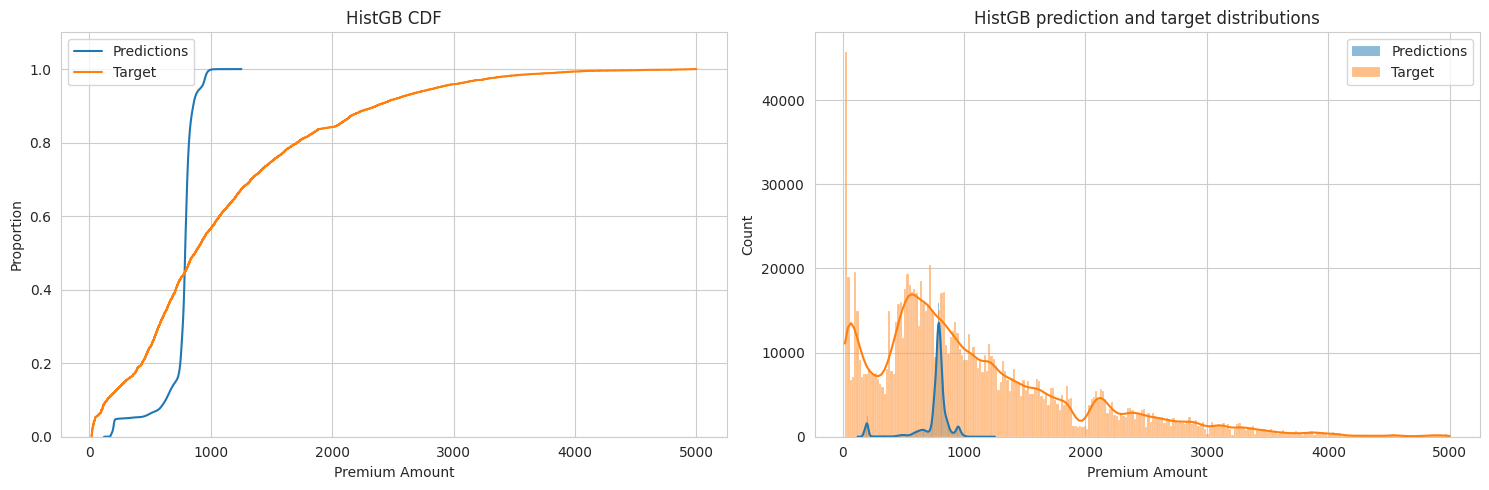

In [11]:
plot_results(oof_preds["HistGB"], y, "HistGB")

## LightGBM (GBDT)

In [12]:
X, y, X_test = get_data("lgbm-gbdt")
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, "lgbm-gbdt")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04625	valid_0's l2: 1.09465
[200]	valid_0's rmse: 1.0463	valid_0's l2: 1.09473
Early stopping, best iteration is:
[113]	valid_0's rmse: 1.04622	valid_0's l2: 1.09457

--- Fold 1 - RMSLE: 1.046216


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04567	valid_0's l2: 1.09343
[200]	valid_0's rmse: 1.04567	valid_0's l2: 1.09343
Early stopping, best iteration is:
[144]	valid_0's rmse: 1.04566	valid_0's l2: 1.0934

--- Fold 2 - RMSLE: 1.045659


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04648	valid_0's l2: 1.09512
[200]	valid_0's rmse: 1.04647	valid_0's l2: 1.09511
Early stopping, best iteration is:
[161]	valid_0's rmse: 1.04645	valid_0's l2: 1.09506

--- Fold 3 - RMSLE: 1.046451


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04419	valid_0's l2: 1.09034
[200]	val

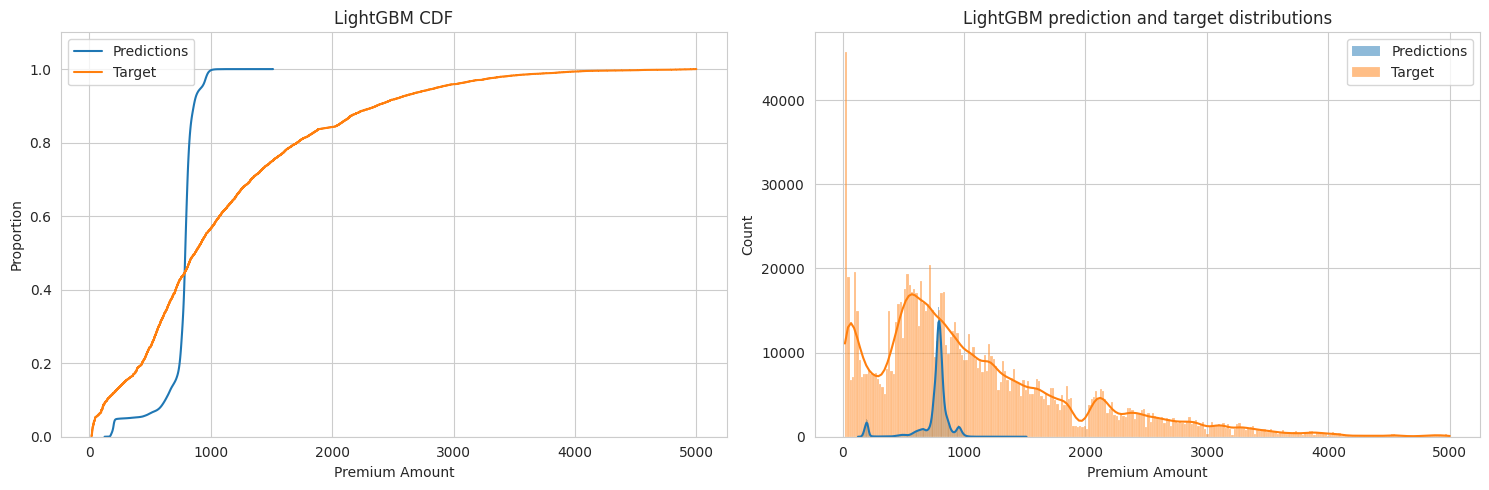

In [13]:
plot_results(oof_preds["LightGBM"], y, "LightGBM")

## LightGBM (GOSS)

In [14]:
X, y, X_test = get_data("lgbm-goss")
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, "lgbm-goss")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04651	valid_0's l2: 1.09519
Early stopping, best iteration is:
[67]	valid_0's rmse: 1.04648	valid_0's l2: 1.09511

--- Fold 1 - RMSLE: 1.046475


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04595	valid_0's l2: 1.09402
Early stopping, best iteration is:
[93]	valid_0's rmse: 1.04592	valid_0's l2: 1.09396

--- Fold 2 - RMSLE: 1.045925


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04688	valid_0's l2: 1.09596
Early stopping, best iteration is:
[66]	valid_0's rmse: 1.04679	valid_0's l2: 1.09578

--- Fold 3 - RMSLE: 1.046795


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.04446	valid_0's l2: 1.09091
Early stopping, best iteration is:
[62]	valid_0's rmse: 1.0444	valid_0's l2: 1.09078

--- Fold 4 - RMSLE: 1.044405


Training until validation scores don't improve fo

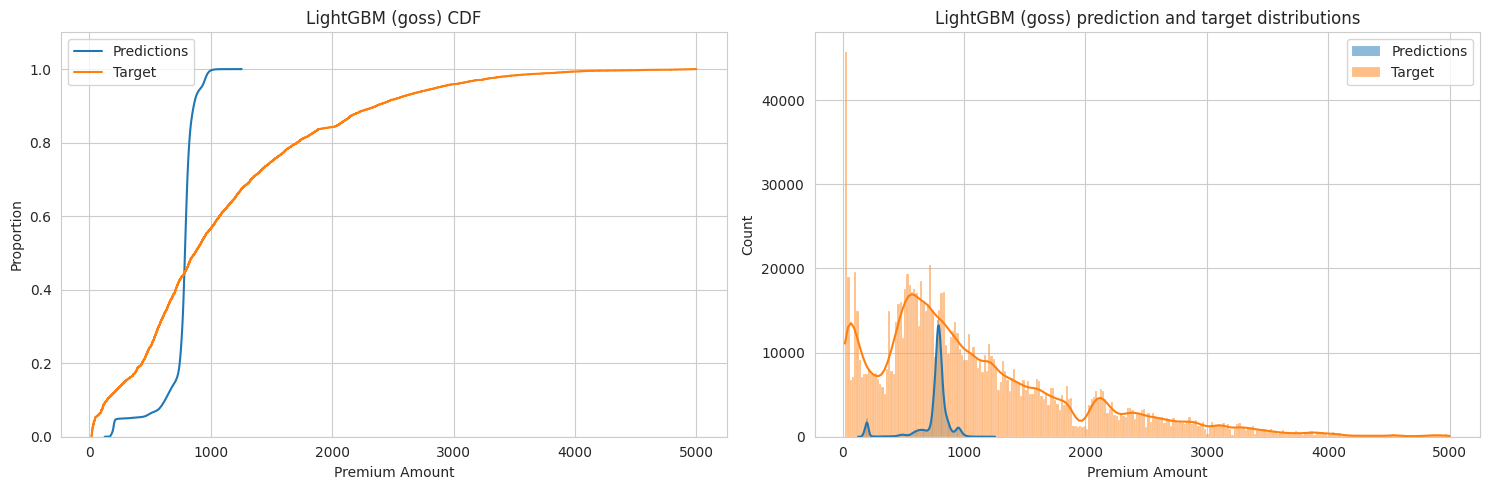

In [15]:
plot_results(oof_preds["LightGBM (goss)"], y, "LightGBM (goss)")

## XGBoost

In [16]:
X, y, X_test = get_data("xgb")
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, "xgb")

Training XGBRegressor

[0]	validation_0-rmse:1.07323
[100]	validation_0-rmse:1.04799
[122]	validation_0-rmse:1.04843

--- Fold 1 - RMSLE: 1.046961


[0]	validation_0-rmse:1.07188
[100]	validation_0-rmse:1.04683
[124]	validation_0-rmse:1.04720

--- Fold 2 - RMSLE: 1.045948


[0]	validation_0-rmse:1.07238
[100]	validation_0-rmse:1.04788
[120]	validation_0-rmse:1.04814

--- Fold 3 - RMSLE: 1.046993


[0]	validation_0-rmse:1.07194
[100]	validation_0-rmse:1.04575
[130]	validation_0-rmse:1.04618

--- Fold 4 - RMSLE: 1.045038


[0]	validation_0-rmse:1.07337
[100]	validation_0-rmse:1.04727
[126]	validation_0-rmse:1.04781

--- Fold 5 - RMSLE: 1.046419



------ Overall RMSLE: 1.046272 - Average RMSLE: 1.046272


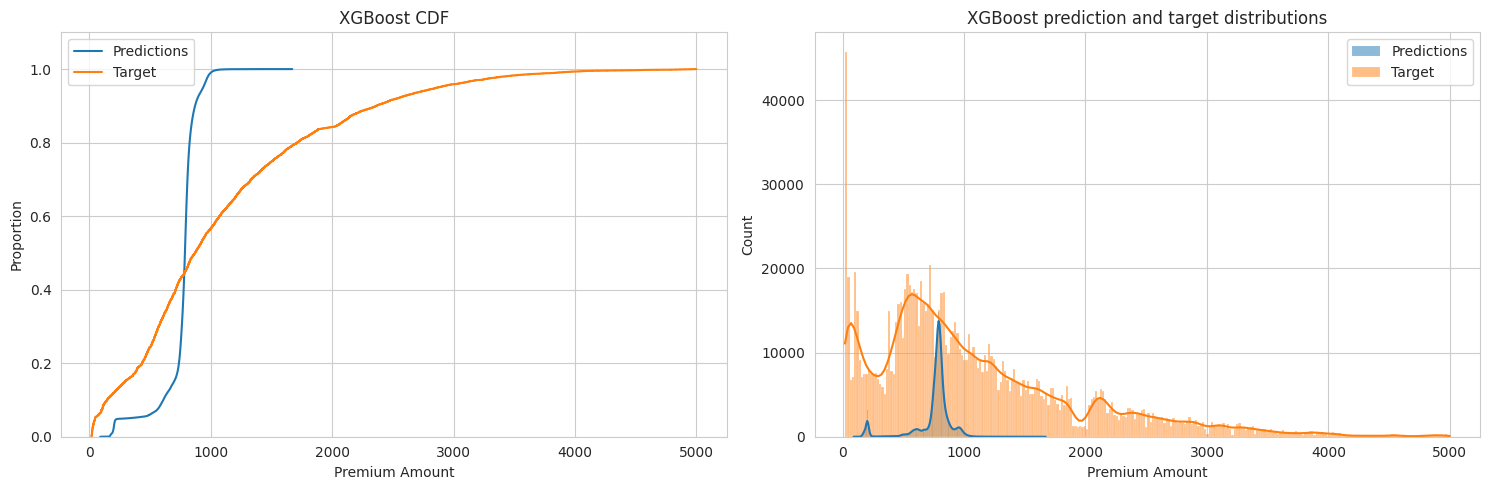

In [17]:
plot_results(oof_preds["XGBoost"], y, "XGBoost")

## CatBoost

In [18]:
X, y, X_test = get_data("cb")
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, "cb")

Training CatBoostRegressor

Learning rate set to 0.149662
0:	learn: 1.0871189	test: 1.0879396	best: 1.0879396 (0)	total: 1.07s	remaining: 17m 45s
250:	learn: 1.0457719	test: 1.0483074	best: 1.0483074 (250)	total: 3m 4s	remaining: 9m 11s
500:	learn: 1.0434698	test: 1.0476695	best: 1.0476604 (474)	total: 6m 13s	remaining: 6m 12s
750:	learn: 1.0415129	test: 1.0475979	best: 1.0475565 (687)	total: 9m 27s	remaining: 3m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.047556451
bestIteration = 687

Shrink model to first 688 iterations.

--- Fold 1 - RMSLE: 1.047556


Learning rate set to 0.149662
0:	learn: 1.0876023	test: 1.0868932	best: 1.0868932 (0)	total: 973ms	remaining: 16m 12s
250:	learn: 1.0457848	test: 1.0468614	best: 1.0468614 (250)	total: 3m 6s	remaining: 9m 15s
500:	learn: 1.0434133	test: 1.0463884	best: 1.0463883 (499)	total: 6m 17s	remaining: 6m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.046316076
bestIteration = 586

Shrink mo

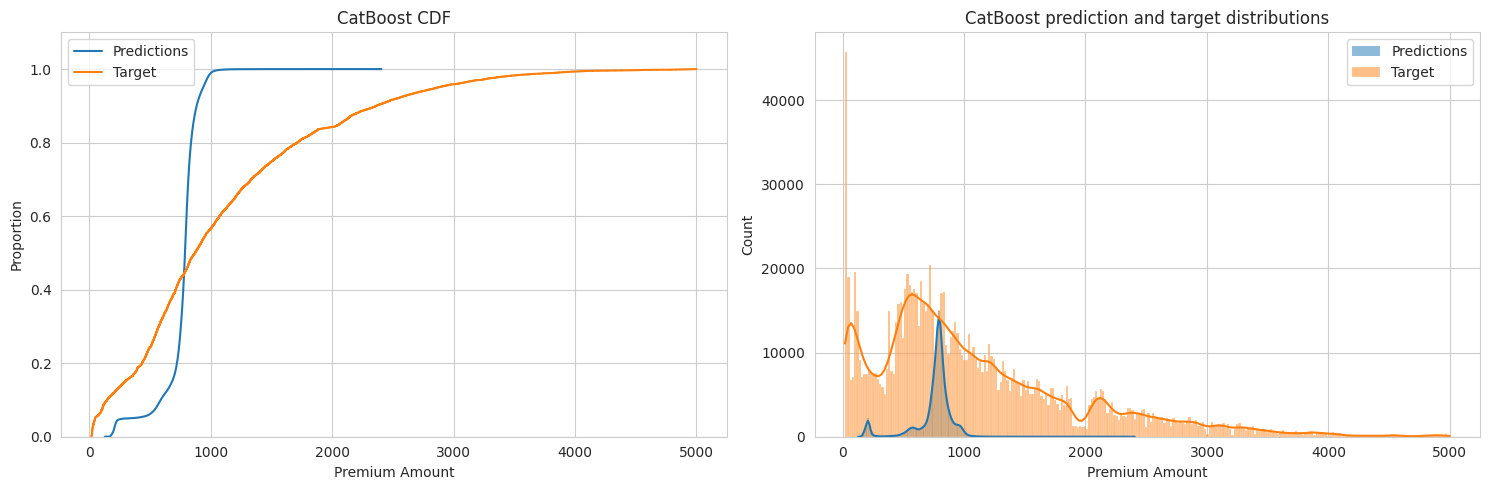

In [19]:
plot_results(oof_preds["CatBoost"], y, "CatBoost")

## AutoGluon

In [20]:
oof_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(pickle.load(open(oof_preds_files[0], 'rb')))
ag_test_preds = np.log1p(pickle.load(open(test_preds_files[0], 'rb')))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

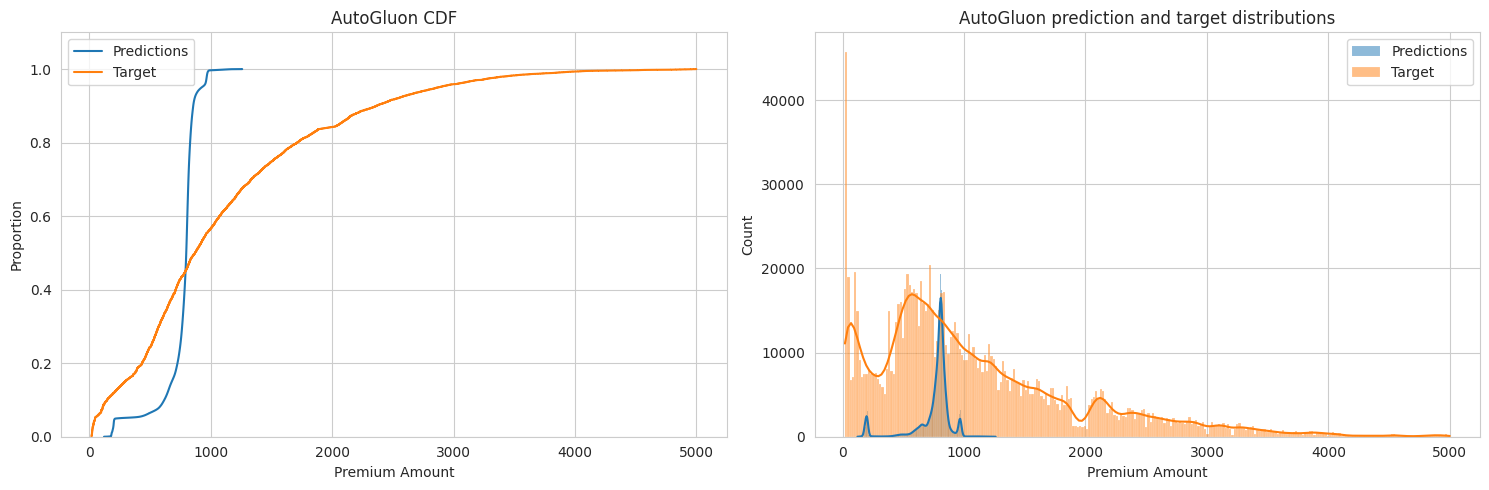

In [21]:
plot_results(oof_preds["AutoGluon"], y, "AutoGluon")

# L2 Ridge

In [22]:
l2_oof_preds = {}
l2_test_preds = {}

In [23]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [24]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [25]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 100),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-05 20:38:54,300] A new study created in memory with name: no-name-74ec3262-1e77-4837-aee6-d9f9c85466a1
[I 2024-12-05 20:39:00,963] Trial 0 finished with value: 1.044606226346689 and parameters: {'alpha': 82.20006284345817, 'tol': 0.00023308013844240062}. Best is trial 0 with value: 1.044606226346689.
[I 2024-12-05 20:39:01,293] Trial 2 finished with value: 1.0446062837755776 and parameters: {'alpha': 47.94334298943996, 'tol': 0.0003725607536868245}. Best is trial 0 with value: 1.044606226346689.
[I 2024-12-05 20:39:01,297] Trial 1 finished with value: 1.0446062215019836 and parameters: {'alpha': 58.167883573456166, 'tol': 0.00031353956098666375}. Best is trial 1 with value: 1.0446062215019836.
[I 2024-12-05 20:39:01,691] Trial 3 finished with value: 1.0446062148915995 and parameters: {'alpha': 79.28750685721312, 'tol': 0.0002872286749907185}. Best is trial 3 with value: 1.0446062148915995.
[I 2024-12-05 20:39:07,822] Trial 4 finished with value: 1.0446062281801392 and parame

In [26]:
ridge_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 69.45776887462051,
  "tol": 0.0005848819851845533
}


In [27]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_preds["L2 Ensemble Ridge"], l2_test_preds["L2 Ensemble Ridge"], scores["L2 Ensemble Ridge"], ridge_coeffs = ridge_trainer.train(X, y, X_test, "ensemble-ridge")

Training Ridge

--- Fold 1 - RMSLE: 1.045157
--- Fold 2 - RMSLE: 1.044348
--- Fold 3 - RMSLE: 1.045209
--- Fold 4 - RMSLE: 1.043042
--- Fold 5 - RMSLE: 1.045275

------ Overall RMSLE: 1.044607 - Average RMSLE: 1.044606


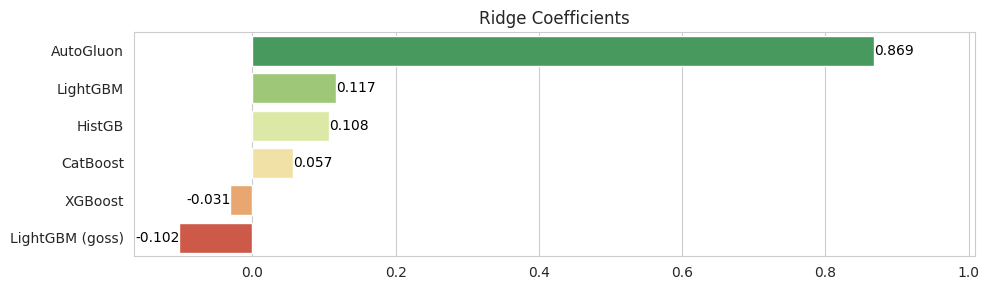

In [28]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

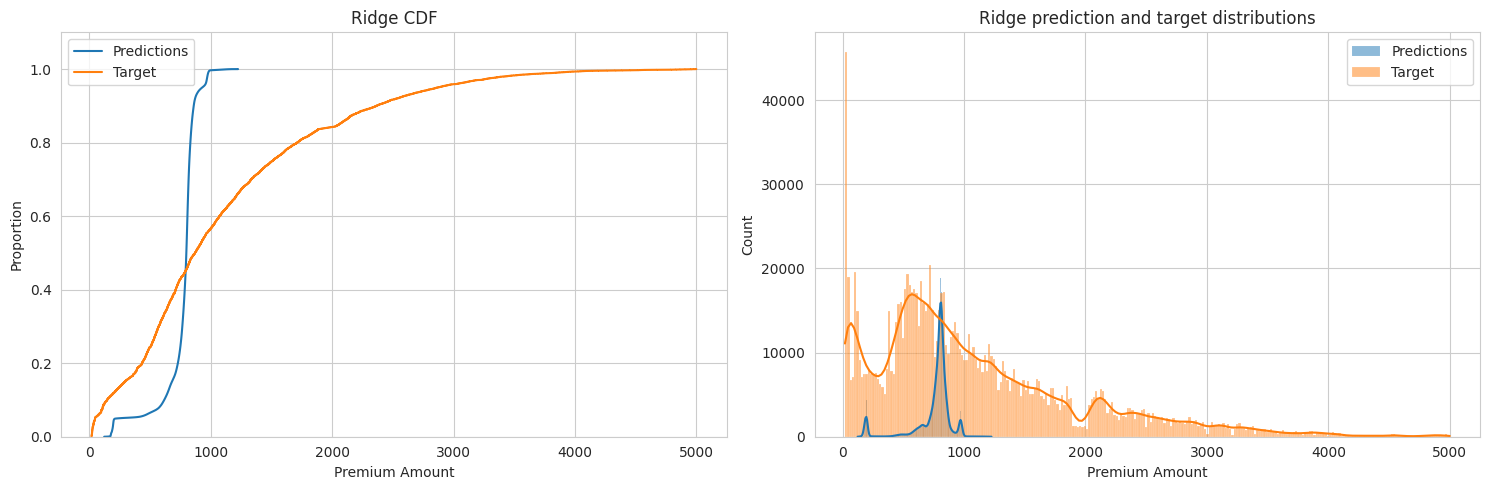

In [29]:
plot_results(l2_oof_preds["L2 Ensemble Ridge"], y, "Ridge")

In [30]:
save_sub("l2-ensemble-ridge", l2_test_preds["L2 Ensemble Ridge"], np.mean(scores["L2 Ensemble Ridge"]))

,id,Premium Amount
0,1200000,838.469614
1,1200001,809.741355
2,1200002,804.256711
3,1200003,819.082488
4,1200004,743.542663
...,...,...
799995,1999995,969.118331
799996,1999996,550.194960
799997,1999997,826.370732
799998,1999998,826.845079


# L2 Lasso

In [31]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [32]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 1),
        'tol': trial.suggest_float('tol', 1e-6, 1e-3)
    }
    
    model = Lasso(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-05 20:46:16,837] A new study created in memory with name: no-name-d8ec76f5-34fa-4f52-8a9b-375a8e7b13f2
[I 2024-12-05 20:46:24,949] Trial 0 finished with value: 1.095826355281642 and parameters: {'alpha': 0.5970515097564285, 'tol': 2.0465059402451807e-05}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-05 20:46:25,427] Trial 1 finished with value: 1.095826355281642 and parameters: {'alpha': 0.6998621104418233, 'tol': 0.00046981630705338236}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-05 20:46:29,877] Trial 2 finished with value: 1.052758538585997 and parameters: {'alpha': 0.04272509017104309, 'tol': 0.00018949764210307585}. Best is trial 2 with value: 1.052758538585997.
[I 2024-12-05 20:46:33,714] Trial 3 finished with value: 1.0472811791115624 and parameters: {'alpha': 0.024444895850897597, 'tol': 0.0001289010482438567}. Best is trial 3 with value: 1.0472811791115624.
[I 2024-12-05 20:46:34,036] Trial 4 finished with value: 1.095826355281642 and par

In [33]:
lasso_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(lasso_params, indent=2))

{
  "random_state": 42,
  "alpha": 2.0574597215961346e-05,
  "tol": 0.0009099408727026871
}


In [34]:
lasso_model = Lasso(**lasso_params)
lasso_trainer = Trainer(lasso_model)
l2_oof_preds["L2 Ensemble Lasso"], l2_test_preds["L2 Ensemble Lasso"], scores["L2 Ensemble Lasso"], lasso_coeffs = lasso_trainer.train(X, y, X_test, "ensemble-ridge")

Training Lasso

--- Fold 1 - RMSLE: 1.045155
--- Fold 2 - RMSLE: 1.044346
--- Fold 3 - RMSLE: 1.045207
--- Fold 4 - RMSLE: 1.043037
--- Fold 5 - RMSLE: 1.045296

------ Overall RMSLE: 1.044608 - Average RMSLE: 1.044608


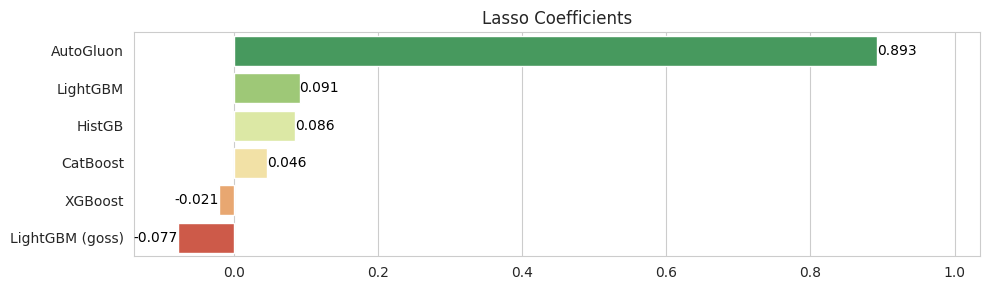

In [35]:
plot_weights(lasso_coeffs, "Lasso Coefficients")

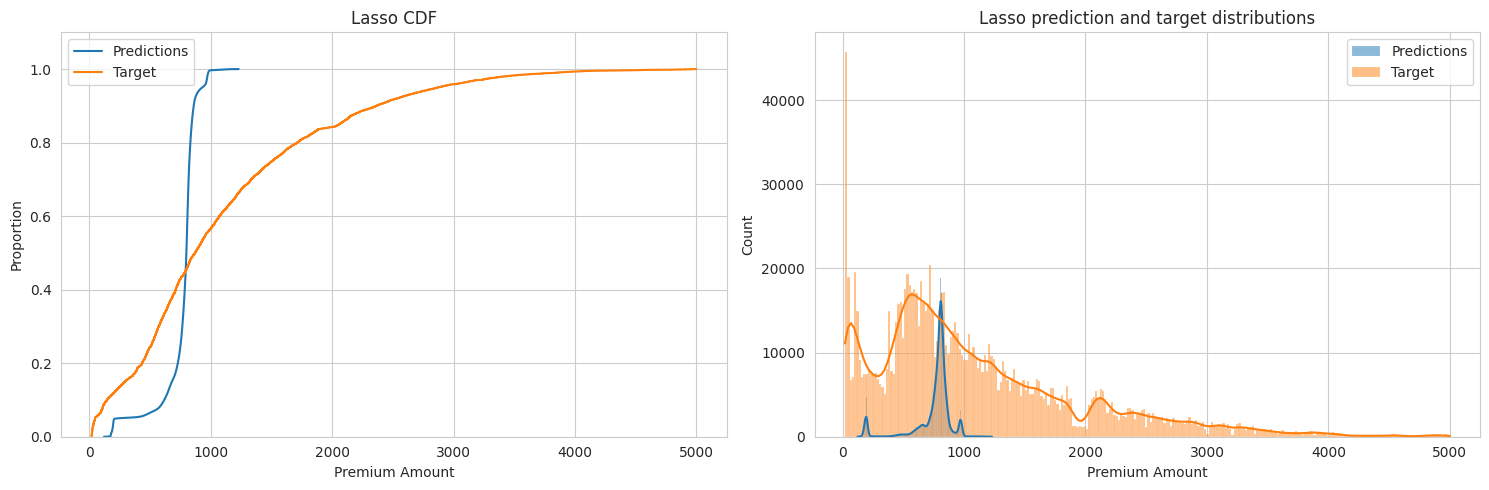

In [36]:
plot_results(l2_oof_preds["L2 Ensemble Lasso"], y, "Lasso")

In [37]:
save_sub("l2-ensemble-lasso", l2_test_preds["L2 Ensemble Lasso"], np.mean(scores["L2 Ensemble Lasso"]))

,id,Premium Amount
0,1200000,834.733568
1,1200001,810.099056
2,1200002,804.167138
3,1200003,819.227814
4,1200004,743.271770
...,...,...
799995,1999995,969.372289
799996,1999996,549.510035
799997,1999997,826.370419
799998,1999998,826.479724


# L3 weighted ensemble

In [38]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_preds.keys()])
    weights /= np.sum(weights)
    
    preds = np.zeros(len(y))
    for model, weight in zip(l2_oof_preds.keys(), weights):
        preds += l2_oof_preds[model] * weight
            
    return root_mean_squared_error(y, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)

[I 2024-12-05 21:10:53,665] A new study created in memory with name: no-name-e28699f5-ff37-499b-9f64-3563a9603621
[I 2024-12-05 21:10:53,726] Trial 0 finished with value: 1.0446076397783786 and parameters: {'L2 Ensemble Ridge': 0.357044135256012, 'L2 Ensemble Lasso': 0.9385798061187998}. Best is trial 0 with value: 1.0446076397783786.
[I 2024-12-05 21:10:53,738] Trial 3 finished with value: 1.0446070764191158 and parameters: {'L2 Ensemble Ridge': 0.43440199133175683, 'L2 Ensemble Lasso': 0.34586507531734656}. Best is trial 1 with value: 1.0446066395942493.
[I 2024-12-05 21:10:53,730] Trial 2 finished with value: 1.044607253753914 and parameters: {'L2 Ensemble Ridge': 0.7391195267647258, 'L2 Ensemble Lasso': 0.8737894895158813}. Best is trial 2 with value: 1.044607253753914.
[I 2024-12-05 21:10:53,733] Trial 1 finished with value: 1.0446066395942493 and parameters: {'L2 Ensemble Ridge': 0.9643670815359278, 'L2 Ensemble Lasso': 0.1234834367264056}. Best is trial 1 with value: 1.044606639

In [39]:
scores['L3 Weighted Ensemble'] = [study.best_value] * CFG.n_folds

In [40]:
best_weights = np.array([study.best_params[l2_model] for l2_model in l2_oof_preds.keys()])
best_weights /= np.sum(best_weights)
print(json.dumps({model: weight for model, weight in zip(l2_oof_preds.keys(), best_weights)}, indent=2))

{
  "L2 Ensemble Ridge": 0.9997013217490716,
  "L2 Ensemble Lasso": 0.0002986782509283956
}


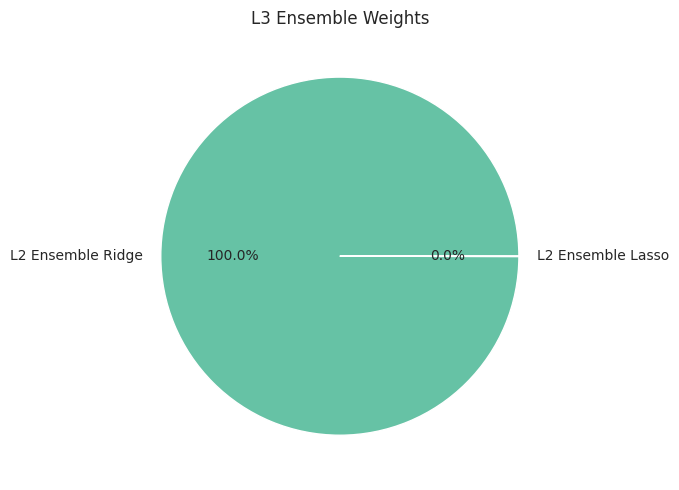

In [41]:
plt.figure(figsize=(8, 5))
plt.pie(
    study.best_params.values(), 
    labels=study.best_params.keys(), 
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', 2)
)
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [42]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_preds.keys(), best_weights):
    weighted_test_preds += l2_test_preds[model] * weight
    
save_sub('l3-weighted-ensemble', weighted_test_preds, np.mean(scores['L3 Weighted Ensemble']))

,id,Premium Amount
0,1200000,838.468495
1,1200001,809.741462
2,1200002,804.256684
3,1200003,819.082531
4,1200004,743.542582
...,...,...
799995,1999995,969.118407
799996,1999996,550.194755
799997,1999997,826.370732
799998,1999998,826.844970


# Results

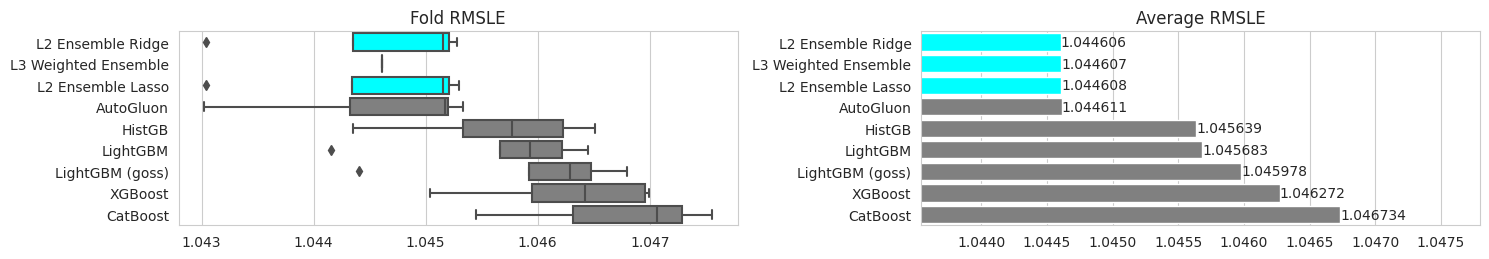

In [43]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

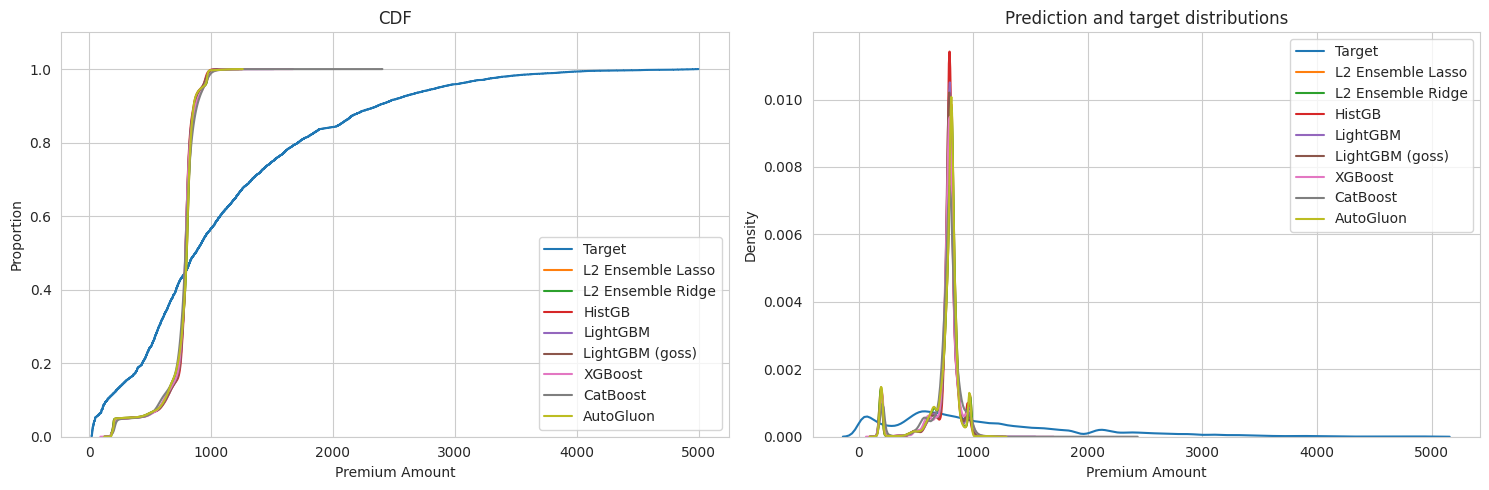

In [44]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(np.expm1(y), label="Target", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), label="L2 Ensemble Lasso", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), label="L2 Ensemble Ridge", ax=axes[0])
for model in oof_preds:
    sns.ecdfplot(np.expm1(oof_preds[model]), label=model, ax=axes[0])
axes[0].set_title("CDF")
axes[0].legend(loc="best")
axes[0].set_ylim(0, 1.1)

sns.kdeplot(np.expm1(y), ax=axes[1], label='Target')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), ax=axes[1], label='L2 Ensemble Lasso')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), ax=axes[1], label='L2 Ensemble Ridge')
for model in oof_preds:
    sns.kdeplot(np.expm1(oof_preds[model]), ax=axes[1], label=model)
axes[1].set_title("Prediction and target distributions")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

In [45]:
shutil.rmtree("catboost_info", ignore_errors=True)